# Intro to Autoencoders

이 자습서에서는 기본 사항, 이미지 노이즈 제거 및 이상 탐지의 세 가지 예가 포함된 자동 인코더를 소개합니다.

- 자동 인코더는 입력 내용을 출력에 복사하도록 훈련된 특수한 유형의 신경 네트워크입니다. 
- 예를 들어, 손으로 쓴 자릿수의 이미지가 주어진 경우 자동 인코더는 먼저 이미지를 저차원 잠재 표현으로 인코딩한 다음 잠재 표현을 다시 이미지로 디코딩합니다. 
- 자동 인코더는 재구성 오류를 최소화하면서 데이터를 압축하는 방법을 학습합니다.

## AutoEncoder란 무엇인가

AutoEncoder에 대한 핵심을 다시 한번 짚어보면 다음과 같습니다

* 입력과 출력이 같은 구조
* Bottleneck Hiddenlayer
    * Bottleneck layer는 다음과 같이 표현하기도 합니다
    * Latent Variable
    * Feature
Hidden representation

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FOHinQ%2FbtqFztcbowJ%2FZu49rG8eWCK4kPJ9GYaKKK%2Fimg.png'>

## AutoEncoder의 수식과 학습 방법

  - Input Data를 Encoder Network에 통과시켜 압축된 z값을 얻습니다

$$z = h_{\phi}(x)$$

  - 압축된 z vector로부터 Input Data와 같은 크기의 출력 값을 생성합니다

$$y = g_{\theta}(z) =  g_{\theta}( h_{\phi}(x))$$

  - 이때 Loss값은 입력값 x와 Decoder를 통과한 y값의 차이입니다

$$L(\theta,\phi) = \frac{1}{n} \sum_{i=1}^{n} (x_{i} -  g_{\theta}( h_{\phi}(x_i)))^2$$

  - 위 loss값이 최소화 하도록 학습을 진행합니다. 

## Import TensorFlow and other libraries

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

## Load the dataset

시작하려면 Fashon MNIST 데이터 집합을 사용하여 기본 자동 인코더를 학습합니다.<br>이 데이터 집합의 각 이미지는 28x28 픽셀입니다.

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/intro_autoencoder_result.png?raw=1)

이미지를 64차원 잠재 벡터로 압축하는 '인코더'와 잠재 공간에서<br> 원래 이미지를 재구성하는 '디코더'의 두 가지 조밀한 레이어로 자동 인코더를 정의합니다.

모델을 정의하려면 [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models)를 사용하십시오.


In [9]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

x_train을 입력 및 대상으로 사용하여 모델을 교육합니다.<br>인코더는 데이터 세트를 784차원에서 잠재 공간으로 압축하는 방법을 학습하고 디코더는 원본 이미지를 재구성하는 방법을 학습합니다.

In [13]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0241 - val_loss: 0.0133
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 0.0094
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.008

In [14]:
autoencoder.summary()

Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64)                50240     
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28)            50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


이제 모델이 교육되었으니 테스트 세트의 이미지를 인코딩하고 디코딩하여 테스트해 보겠습니다.

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

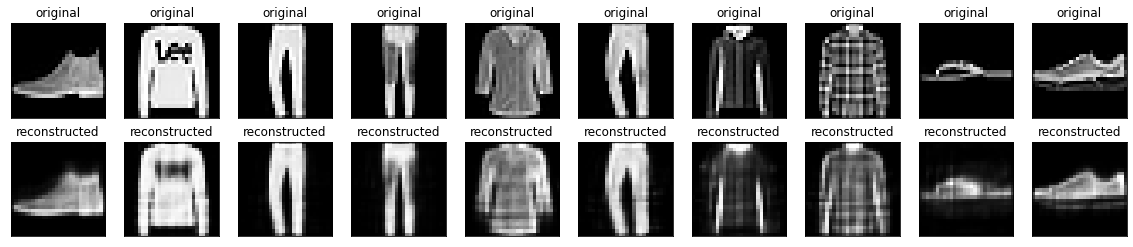

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Denoizing Autoencoder(DAE)

<img src= 'https://929687.smushcdn.com/2407837/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png?lossy=1&strip=1&webp=0'>

소음 제거 자동 인코더 절차는 다음을 돕기 위해 개발되었습니다.
- 자동 인코더의 숨겨진 레이어가 보다 강력한 필터를 학습합니다.
- 자동 인코더의 과다 장착 위험 감소
- 자동 인코더가 간단한 식별 기능을 학습하지 못하게 합니다.

OCR(광학 문자 인식) 알고리즘의 정확도를 높이기 위해 이미지를 전처리하는 것이 좋은 예입니다.<br> OCR을 사용한 적이 있는 경우, 약간의 잘못된 노이즈(예: 프린터 잉크 얼룩, 스캔 중 이미지 품질 저하 등)가 OCR 메서드의 성능을 크게 해칠 수 있습니다.<br> 노이즈 제거 자동 인코더를 사용하여 이미지를 자동으로 전처리하고 품질을 개선하여 다운스트림 OCR 알고리즘의 정확도를 높일 수 있습니다.
<hr>

__Image Denoizing Example__

![Image denoising results](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/image_denoise_fmnist_results.png?raw=1)

영상에서 노이즈를 제거하도록 자동 인코더를 교육할 수도 있습니다.<br> 다음 섹션에서는 각 이미지에 무작위 노이즈를 적용하여 패션 MNIST 데이터 세트의 노이즈 버전을 만듭니다.<br> 그런 다음 노이즈가 있는 이미지를 입력으로 사용하고 원본 이미지를 대상으로 자동 인코더를 교육합니다.

앞에서 수정한 내용을 생략하도록 데이터 집합을 다시 가져오겠습니다.


In [22]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [23]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


이미지에 임의 노이즈 추가

In [24]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

노이즈가 많은 이미지를 플롯합니다.

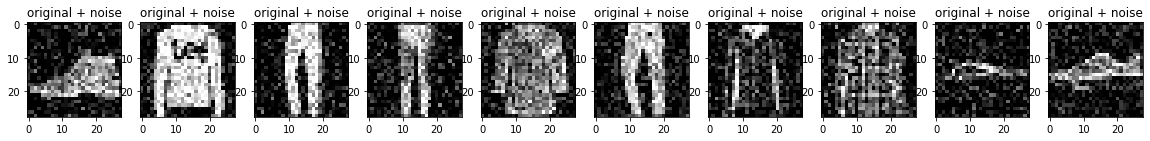

In [25]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Define a convolutional autoencoder

이 예에서는 인코더의 Conv2D 레이어와 디코더의<br> Conv2D Transpose 레이어를 사용하여 컨볼루션 자동 인코더를 교육합니다.

In [26]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [27]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [28]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0186 - val_loss: 0.0109
Epoch 2/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 3/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 4/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 5/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 7/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 9/10
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/10
1875/1875 [==============================] - 61s 33m

인코더에 대한 요약을 살펴보겠습니다. 이미지가 28x28에서 7x7로 다운샘플링됩니다.

In [80]:
autoencoder.encoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [31]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


자동 인코더에 의해 생성되는 노이즈 제거된 이미지와 노이즈 제거된 이미지를 모두 표시합니다.

In [32]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy() # x_test가 들어가면? 노이즈 없는거 아닌가
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

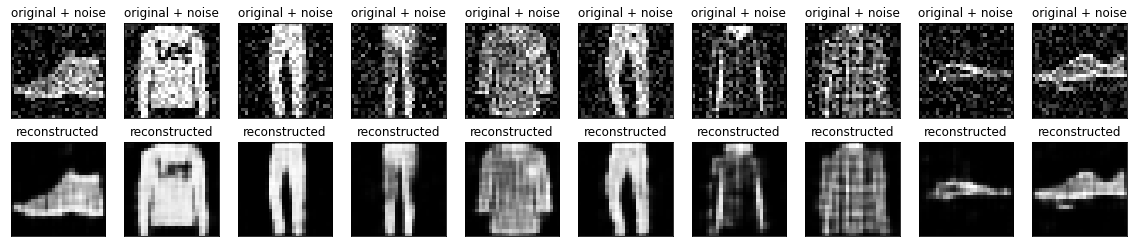

In [33]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

Autoencoder를 이용하면 데이터에 대한 labeling을 하지 않아도 데이터의 주성분이 되는 정상 영역의 특징들을 배울 수 있습니다.<br>
이때, 학습된 autoencoder에 정상 sample을 넣어주면 위의 그림과 같이 잘 복원을 하므로 input과 output의 차이가 거의 발생하지 않는 반면,<br> 비정상적인 sample을 넣으면 autoencoder는 정상 sample처럼 복원하기 때문에 input과 output의 차이를 구하는 과정에서<br> 차이가 도드라지게 발생하므로 비정상 sample을 검출할 수 있습니다.

다만 Autoencoder의 code size (= latent variable의 dimension) 같은 hyper-parameter에 따라 전반적인 복원 성능이 좌우되기 때문에<br> 양/불 판정 정확도가 Supervised Anomaly Detection에 비해 다소 불안정하다는 단점이 존재합니다.<br> 또한 autoencoder에 넣어주는 input과 output의 차이를 어떻게 정의할 것인지(= 어떤 방식으로 difference map을 계산할지)<br> 어느 loss function을 사용해 autoencoder를 학습시킬지 등 여러 가지 요인에 따라 성능이 크게 달라질 수 있습니다.<br> 이렇듯 성능에 영향을 주는 요인이 많다는 약점이 존재하지만<br> 별도의 Labeling 과정 없이 어느정도 성능을 낼 수 있다는 점에서 장단이 뚜렷한 방법론이라 할 수 있습니다.

## ECG Dataset Overview

이 예에서는 ECG5000 데이터 집합에서 이상을 감지하도록 자동 인코더를 교육합니다.<br> 이 데이터 세트에는 각각 140개의 데이터 포인트가 있는 5,000개의 심전도가 포함되어 있습니다.<br> 데이터 세트의 단순화된 버전을 사용합니다.<br> 여기서 각 예는 0(비정상 리듬에 해당) 또는 1(정상 리듬에 해당)로 라벨이 지정됩니다.<br> 비정상적인 리듬을 확인하는 데 관심이 있습니다.

참고: 이 데이터 집합은 레이블이 지정되어 있으므로 감독된 학습 문제로 간주할 수 있습니다.<br> 이 예제의 목적은 라벨을 사용할 수 없는 대규모 데이터 집합<br>(예: 수천 개의 정규 리듬과 소수의 비정상 리듬만 있는 경우)에 적용할 수 있는 이상 징후 탐지 개념을 설명하는 것입니다.

자동 인코더를 사용하여 이상 징후를 감지하는 방법은 무엇입니까?<br> 재구성 오류를 최소화하도록 자동 인코더가 교육되어 있다는 점을 기억하십시오.<br> 일반 리듬에서만 자동 인코더를 학습한 다음 이 인코더를 사용하여 모든 데이터를 재구성합니다.<br> 우리의 가설은 비정상적인 리듬은 재구성 오류가 더 클 것이라는 것입니다.<br> 그런 다음 재구성 오류가 고정 임계값을 초과할 경우 리듬을 변칙으로 분류합니다.

## Load ECG data

사용할 데이터 집합은 timeseriesclassification.com의 데이터 집합을 기반으로 합니다.

In [34]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [35]:
# The last element contains the labels
# 마지막 요소는 레이블을 포함합니다.
labels = raw_data[:, -1]
print(labels.shape)

# The other data points are the electrocadriogram data
# 다른 데이터 포인트는 전기전도 데이터입니다.
data = raw_data[:, 0:-1]

print(data.shape)
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

(4998,)
(4998, 140)



Normalize the data to [0,1].

In [36]:
# min max 일반화
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

이 데이터 집합에서 1로 라벨이 지정된 일반 리듬만 사용하여 자동 인코더를 교육합니다. 정상적인 리듬과 비정상적인 리듬을 구분하세요.

In [37]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels] # ~ 보수 연산
anomalous_test_data = test_data[~test_labels]

정상 심전도를 표시합니다.

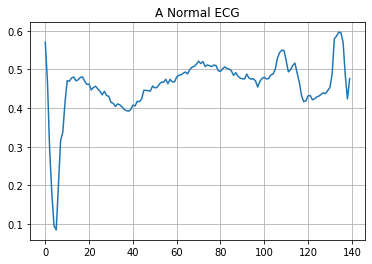

In [45]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title('A Normal ECG')
plt.show()

비정상 심전도를 표시합니다.

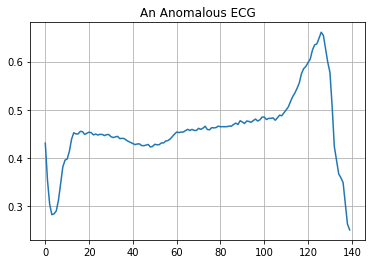

In [46]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

## Build the model

In [47]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [48]:
autoencoder.compile(optimizer='adam', loss='mae')

자동 인코더는 일반 심전도만 사용하여 교육되지만 전체 테스트 세트를 사용하여 평가됩니다.

In [49]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0583 - val_loss: 0.0536
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0568 - val_loss: 0.0525
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0553 - val_loss: 0.0512
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0533 - val_loss: 0.0495
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0505 - val_loss: 0.0475
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0469 - val_loss: 0.0458
Epoch 7/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0428 - val_loss: 0.0445
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0390 - val_loss: 0.0425
Epoch 9/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0353 - val_loss: 0.0402
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0321 - val_loss: 0.0388
Epoch 11/20
5/5 [=============

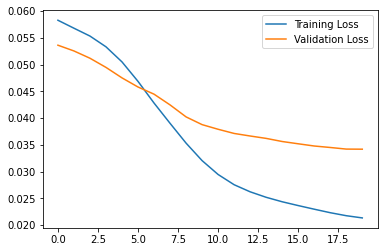

In [50]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

재구성 오차가 정규 교육 예시에서 표준 편차가 1개 이상일 경우 심전도(ECG)를 변칙적인 것으로 곧 분류할 것입니다.<br> 먼저 교육 세트의 정상 심전도, 자동 인코더에 의해 인코딩 및 디코딩된 후의 재구성 및 재구성 오류를 플롯으로 표시합니다.

(560, 8)


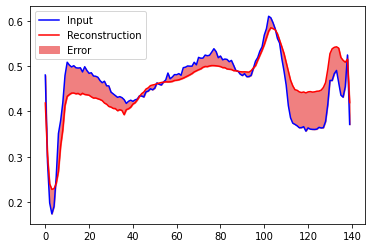

In [54]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

이번에는 비정상적인 검정 예제를 위해 유사한 그림을 만듭니다.

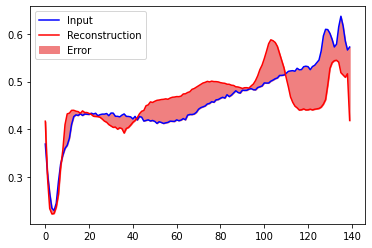

In [55]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

## Detect anomalies

재구성 손실이 고정 임계값보다 큰지 여부를 계산하여 이상 징후를 탐지합니다.<br> 이 자습서에서는 교육 세트의 정규 예제에 대한 평균 평균 오차를 계산한 다음 재구성 오차가 교육 세트의 표준 편차보다 클 경우<br> 향후 예제를 변칙적인 것으로 분류합니다.

교육 세트의 정상 심전도 재구성 오류 표시

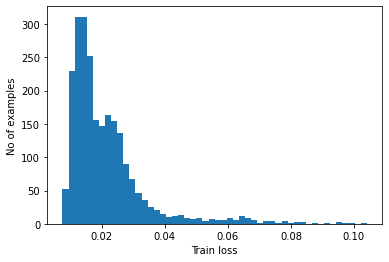

In [56]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

평균 위의 표준 편차 중 하나인 분계점을 선택합니다.

In [57]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03356787


참고: 테스트 예제를 변칙적인 것으로 분류해야 하는 임계값을 선택할 때 사용할 수 있는 다른 전략이 있습니다.<br> 올바른 접근 방식은 데이터 집합에 따라 다릅니다. <br>자세한 내용은 이 튜토리얼의 끝 부분에 있는 링크를 참조하십시오.

테스트 세트의 비정상적인 예제에 대해 재구성 오류를 검사하면 대부분 임계값보다 재구성 오류가 더 큰 것을 알 수 있습니다.<br> 임계값을 변경하여 분류기의 정밀도 및 리콜을 조정할 수 있습니다.

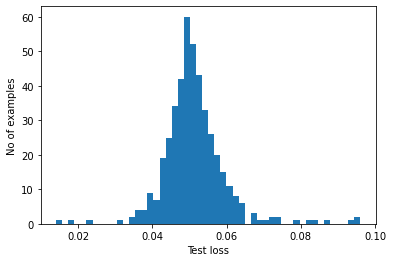

In [59]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel('Test loss')
plt.ylabel('No of examples')
plt.show()

재구성 오류가 임계값보다 큰 경우 심전도를 변칙으로 분류합니다.

In [62]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions))) # 정확도 (전체 대비 정확하게 예측한 개수의 비율)
  print("Precision = {}".format(precision_score(labels, predictions))) # 정밀도 (Positive라고 예측한 것 중에서 얼마나 잘 맞았는지 비율)
  print("Recall = {}".format(recall_score(labels, predictions))) # 예측율(실제 Positive 데이터 중 Positive라고 예측한 비율)

In [64]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9921722113502935
Recall = 0.9053571428571429


# Next steps

자동 인코더를 사용한 이상 감지에 대해 자세히 알아보려면 Victor Dibia가 TensorFlow.js로 구축한 이 훌륭한 대화형 사례를 확인하십시오.<br> 실제 사용 사례에서는 Airbus가 TensorFlow를 사용하여 ISS 원격 분석 데이터에서 이상 징후를 탐지하는 방법을 확인할 수 있습니다.<br> 기초에 대해 자세히 알아보려면 프랑수아 촐레의 블로그 글을 읽어보는 것이 좋다.<br> 자세한 내용은 Ian Goodfellow, Yoshua Bengio 및 Aaron Courville의 Deep Learning 14장을 참조하십시오.